In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle
import keras
from sklearn.metrics import f1_score

from keras.utils import to_categorical

import os
import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "./hub_dataset/inception"
BOTTLE_DIR = "./inception_bottleneck"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/validation"
file_tail = "_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt"

In [4]:
NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(BOTTLE_DIR + "/*/*.txt")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.1)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.copy(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.copy(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.txt"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.txt"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 145134
Validation: 16126


In [9]:
from tqdm import tqdm

def features_from_bottles(bottles):
    X = []
    y = []
    for bottle in tqdm(bottles):
        label = bottle.split("/")[-1].replace(file_tail, "")
        line = open(bottle).readlines()
        X.append( np.loadtxt(line[0].split(','), dtype=np.float32) )
        y.append(label)
        
    X = np.array(X)
    return (X, y)

In [10]:

bottles = glob.glob(VAL_DIR + "/*.txt")
x_val, y_val = features_from_bottles(bottles)


bottles = glob.glob(TRAIN_DIR + "/*.txt")
x_train, y_train = features_from_bottles(bottles)


100%|██████████| 145134/145134 [19:29<00:00, 124.60it/s]


In [11]:
mvc_label = pd.read_csv( './mvc_label.csv', index_col='filename')
mvc_label.head(10)

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,BalconetteBras,Bandeau,BandeauBras,...,Yellow,ZebraPrint,Zipper,fiftyU,halfZip,hundred1U,hundred2O,hundred2U,quarter3Zip,quarterZip
filename,,,,,,,,,,,,,,,,,,,,,
p7258521_s3163710_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
y_train = np.array([mvc_label.loc[label] for label in y_train])
y_val   = np.array([mvc_label.loc[label] for label in y_val])

In [13]:
y_train.shape

(145134, 264)

In [14]:
y_val.shape

(16126, 264)

In [15]:
np.savez_compressed('./mvc_inception_train', x_train=x_train, y_train=y_train)
np.savez_compressed('./mvc_inception_valid', x_val=x_val, y_val=y_val)

In [16]:
print("Validation examples:", len(x_val))
print("Y val examples:", len(y_val))
print("Train examples:", len(x_train))
print("Y examples:", len(y_train))

Validation examples: 16126
Y val examples: 16126
Train examples: 145134
Y examples: 145134


In [17]:
# Plotting on keras training
# https://github.com/stared/livelossplot/
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,4))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="train loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        ax1.set_title("Loss Curves")
        ax1.set_ylabel("Loss")
        ax1.set_xlabel("Epochs")
        
        ax2.plot(self.x, self.acc, label="train accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        ax2.set_title("Accuracy Curves")
        ax2.set_ylabel("Accuracy")
        ax2.set_xlabel("Epochs")
        
        plt.show();

plot_losses = PlotLearning()

In [18]:
model = Sequential()
model.add(Dense(1024, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 264)               270600    
Total params: 2,372,872
Trainable params: 2,370,824
Non-trainable params: 2,048
_________________________________________________________________


In [19]:
x_train.shape[1]

2048

https://github.com/suhongs/dog-project/blob/master/dog_app.ipynb

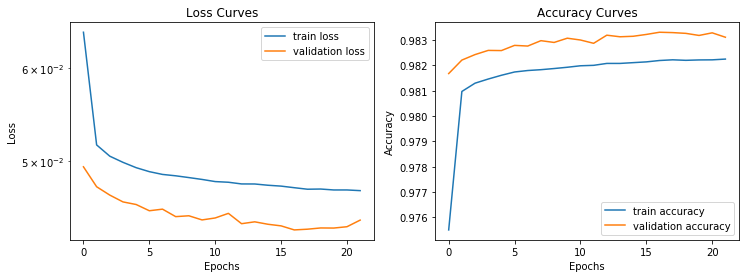

Epoch 23/640
 30272/145134 [=====>........................] - ETA: 27s - loss: 0.0472 - acc: 0.9823

KeyboardInterrupt: 

In [20]:
filepath="./hub_model/inception/weights-improvement-{epoch:02d}-l_{val_loss:.4f}-{loss:.4f}_-ac_{val_acc:.4f}.hdf5"
mc_top = ModelCheckpoint(filepath,
                         monitor='val_loss', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)


history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20,
                    batch_size=32, callbacks=[mc_top, plot_losses], verbose=1)

In [21]:
preds = model.predict(x_val)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

result = preds.reshape(-1) == y_val.reshape(-1)
acc_on_test = sum(result)/len(result)
print("Accuracy", acc_on_test)

Accuracy 0.983231718775251


In [22]:
for weights in glob.glob('./hub_model/inception/*weights-improvement*.hdf5'):
    print(weights)
    model.load_weights(weights)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    scores = model.evaluate(x_val, y_val, verbose=0)
    y_pred = model.predict(x_val)
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    f1_value = f1_score(y_val, y_pred, average='samples')
    print("Scores:", scores, "F1:", f1_value)
    print("-\n")

./hub_model/inception/weights-improvement-02-l_0.0476-0.0516_-ac_0.9822.hdf5
Scores: [0.047570750198617964, 0.9822122972034926] F1: 0.6246929856422835
-

./hub_model/inception/weights-improvement-03-l_0.0468-0.0505_-ac_0.9824.hdf5
Scores: [0.0467986702285111, 0.9824295743780574] F1: 0.6347397125327867
-

./hub_model/inception/weights-improvement-10-l_0.0446-0.0483_-ac_0.9831.hdf5
Scores: [0.044582870149548114, 0.983076703322225] F1: 0.6443099949892803
-

./hub_model/inception/weights-improvement-13-l_0.0443-0.0478_-ac_0.9832.hdf5
Scores: [0.04425531271237542, 0.9831957943856708] F1: 0.6474163072409083
-

./hub_model/inception/weights-improvement-08-l_0.0449-0.0486_-ac_0.9830.hdf5
Scores: [0.044871146983693315, 0.9829792215113573] F1: 0.6456160360067271
-

./hub_model/inception/weights-improvement-04-l_0.0462-0.0499_-ac_0.9826.hdf5
Scores: [0.04618124130008594, 0.9825947031214266] F1: 0.6362526159467671
-

./hub_model/inception/weights-improvement-16-l_0.0441-0.0476_-ac_0.9832.hdf5
Scor

In [53]:
attr=pd.Series(mvc_label.columns.values)

In [346]:
val_bottles = glob.glob('./hub_dataset/validation/*.txt')
x_val.shape[0]

16126

In [348]:
len(val_bottles)

16126

In [349]:
i = random.randint(0, x_val.shape[0])
im_path = val_bottles[i].replace(file_tail, "").replace("hub_dataset/validation/", "rename/")
print(im_path)
pred = model.predict(x_val[i:i+1])
indexes = np.where(pred[0,:] > 0.5)

./rename/p8612127_s3351374_v0.jpg


In [350]:
attr.iloc[indexes]

155     Polyester
191    Sleeveless
261     hundred2U
dtype: object

In [351]:
actual_idx = np.where(y_val[i] > 0)[0]
attr.iloc[actual_idx]

17          Boatneck
93      GraphicPrint
106       KneeLength
155        Polyester
178    SheathDresses
191       Sleeveless
261        hundred2U
dtype: object

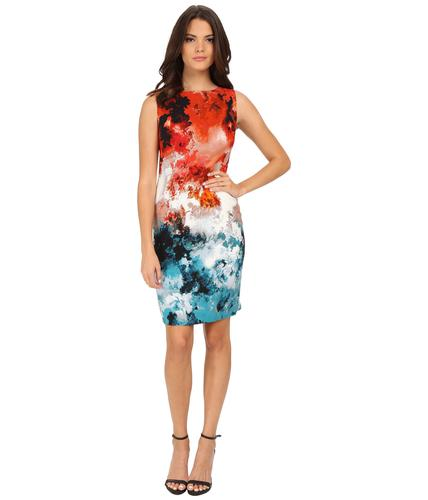

In [352]:
from IPython.display import Image
Image(im_path)

In [334]:
showfit = np.load('../showfit/showfit_val.npz')

In [335]:
shofit_x = showfit['x_val']
shofit_y = showfit['y_val']

In [408]:
val_bottles = glob.glob('../showfit/hub_dataset/validation/*/*.txt')
shofit_x.shape[0]

20096

In [530]:
i = random.randint(0, shofit_x.shape[0])
im_path = val_bottles[i].replace(file_tail, "").replace("../showfit/hub_dataset/validation/", "../showfit/data/")
print(im_path)
pred = model.predict(shofit_x[i:i+1])
indexes = np.where(pred[0,:] > 0.5)

../showfit/data/OUTER/185442_1_3.jpg


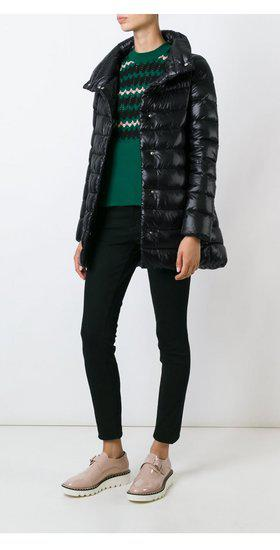

In [531]:
Image(im_path)

In [532]:
showfit_pred = model.predict(shofit_x[i:i+1])
indexes = np.where(showfit_pred[0,:] > 0.5)
attr.iloc[indexes]

13                Black
105    InsulatedJackets
155           Polyester
260           hundred2O
dtype: object